In [1]:
import torch
import matplotlib.pyplot as plt

xs = torch.arange(9).repeat(9)

In [2]:
ys = torch.arange(9).repeat_interleave(9)

blocks = torch.arange(3).repeat_interleave(3).repeat(3)
blocks = torch.concat((blocks , blocks + 3, blocks + 6))



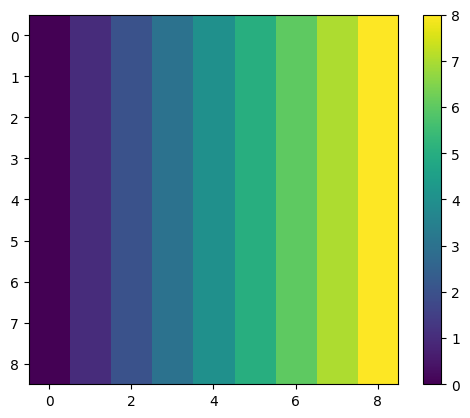

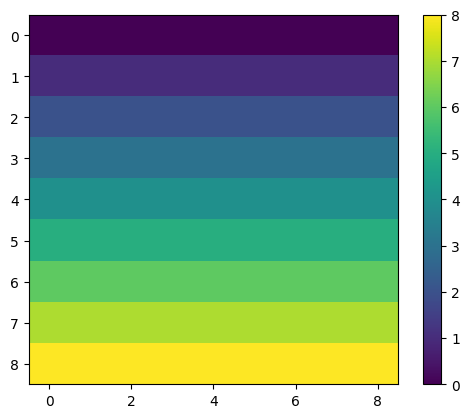

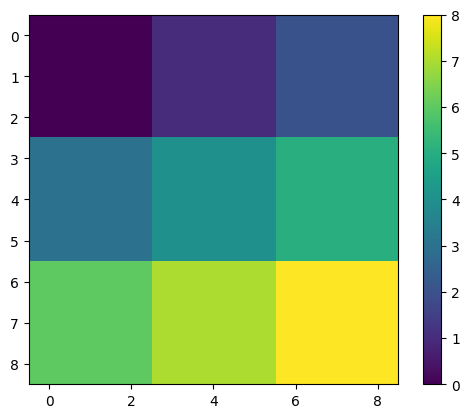

In [3]:
plt.imshow(xs.reshape(9,9).numpy())
plt.colorbar()
plt.show()

plt.imshow(ys.reshape(9,9).numpy())
plt.colorbar()
plt.show()

plt.imshow(blocks.reshape(9,9).numpy())
plt.colorbar()
plt.show()

In [7]:
positional_embedding = torch.concat((
    torch.nn.functional.one_hot(xs, 9),
    torch.nn.functional.one_hot(ys, 9),
    torch.nn.functional.one_hot(blocks, 9),
), axis = 1)
positional_embedding.shape

torch.Size([81, 27])

In [28]:
input = torch.randint(0,10,(4,9,9))

obs = input.reshape((-1, 81)).to(torch.int64)

obs = torch.nn.functional.one_hot(obs, 10)
print(obs.shape)

to_batch_size = positional_embedding[None, :].repeat(4,1,1)

obs = torch.concat((obs, to_batch_size), -1).float()
obs.shape

torch.Size([4, 81, 10])


torch.Size([4, 81, 37])

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SudokuTransformer(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4):
        super(SudokuTransformer, self).__init__()
        
        # Create the positional embeddings
        xs = torch.arange(9).repeat(9)
        ys = torch.arange(9).repeat_interleave(9)

        blocks = torch.arange(3).repeat_interleave(3).repeat(3)
        blocks = torch.cat((blocks, blocks + 3, blocks + 6))
        
        self.positional_embedding = torch.cat((
            F.one_hot(xs, 9),
            F.one_hot(ys, 9),
            F.one_hot(blocks, 9),
        ), axis=1)
        
        # Transformation Layers
        self.to_embed_dim = nn.Linear(37, embed_dim)
        self.layer = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer1 = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.bigger = nn.Linear(embed_dim, embed_dim * 4)
        self.smaller = nn.Linear(embed_dim * 4, embed_dim)
        self.output = nn.Linear(embed_dim, 9)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        # Inputs Preprocessing
        obs = inputs.reshape((-1, 81)).to(torch.int64)
        obs = F.one_hot(obs, 10)
        to_batch_size = self.positional_embedding[None, :].repeat(inputs.size(0),1,1)
        obs = torch.cat((obs, to_batch_size), -1).float()

        # Transformer Layers
        x = self.to_embed_dim(obs)
        
        x = self.relu(x) + x
        x = self.layer(x, x, x)[0] + x
        x = self.relu(self.smaller(self.relu(self.bigger(x)))) + x
        x = self.layer1(x, x, x)[0] + x
        x = self.output(x)
        
        return x

# Example Usage
model = SudokuTransformer(128, 4)
inputs = torch.randint(0, 10, (4, 9, 9))
output = model(inputs)

In [54]:
sum(p.numel() for p in model.parameters())

269833